In [17]:
import os.path

from sympy.printing.pytorch import torch

file_path = '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [5]:
import pandas as pd

edges_df = pd.read_parquet(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [19]:
edges_df

,u,i,ts,idx,rt,0,1,2,3,4
3797497,17684,18738,60000,3797498,1.0,0.0,0.0,1.0,0.0,0.0
3797498,35482,19355,60000,3797499,0.0,0.0,0.0,0.0,0.0,1.0
3797499,18679,59226,60000,3797500,1.0,0.0,0.0,1.0,0.0,0.0
3797500,33545,14046,60000,3797501,0.0,0.0,0.0,1.0,0.0,0.0
3797501,969,17869,60000,3797502,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7393462,10077,35136,119999,7393463,0.0,0.0,0.0,1.0,0.0,0.0
7393463,44631,44354,119999,7393464,1.0,0.0,0.0,0.0,0.0,1.0
7393464,37176,37400,119999,7393465,1.0,0.0,0.0,1.0,0.0,0.0
7393465,37106,22350,119999,7393466,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
u, i, ts = edges_df['u'].to_numpy(), edges_df['i'].to_numpy(), edges_df['ts'].to_numpy()

In [21]:
from temporal_random_walk import TemporalRandomWalk

temporal_random_walk = TemporalRandomWalk(is_directed=True, use_gpu=False)

In [22]:
from raphtory import Graph
g = Graph()

In [23]:
g.load_edges_from_pandas(
    df=edges_df,
    time="ts",
    src="u",
    dst="i"
)

In [24]:
temporal_random_walk.add_multiple_edges(u, i, ts)

In [26]:
import pandas as pd

df = pd.read_parquet('/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_100.parquet')

In [28]:
df

,u,i,ts,idx,rt,0,1,2,3,4
335204989,14938,14938,6000000,335204990,3.0,0.0,0.0,0.0,0.0,1.0
335204990,16284,17932,6000000,335204991,0.0,0.0,0.0,1.0,0.0,0.0
335204991,43759,28205,6000000,335204992,1.0,0.0,0.0,1.0,0.0,0.0
335204992,66999,66999,6000000,335204993,NaN,0.0,0.0,1.0,0.0,0.0
335204993,5870,2402,6000000,335204994,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
338246044,28012,37927,6059999,338246045,1.0,1.0,0.0,0.0,0.0,0.0
338246045,51804,20354,6059999,338246046,0.0,0.0,0.0,0.0,1.0,0.0
338246046,32740,32740,6059999,338246047,0.0,0.0,0.0,0.0,0.0,1.0
338246047,67001,31913,6059999,338246048,6.0,0.0,1.0,0.0,0.0,0.0


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

def plot_contact_sequence(edges, output_path='contact-sequence.pdf'):
    timestamps = [edge[2] for edge in edges]
    max_ts_lim = np.max(timestamps) + np.max(timestamps) * 0.05

    nodes = sorted(set(u for u, v, _ in edges) | set(v for u, v, _ in edges))
    node_to_y = {node: i for i, node in enumerate(nodes)}

    # Use high-contrast colormap
    use_grayscale = False
    if use_grayscale:
        colors = [str(0.85 - 0.1 * (i % 4)) for i in range(len(nodes))]
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, len(nodes)))

    # Configure fonts for ACM conference standard
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman', 'DejaVu Serif'],
        'font.size': 12,
        'axes.labelsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'text.usetex': False
    })

    fig, ax = plt.subplots(figsize=(7, 5))  # ACM conference column width

    # Background node bands and dashed timelines
    for i, node in enumerate(nodes):
        ax.axhspan(i - 0.3, i + 0.3, color=colors[i % len(colors)], alpha=0.15, zorder=0)
        ax.hlines(y=i, xmin=0, xmax=max_ts_lim, color='lightgray', linestyle='--', linewidth=0.6, zorder=1)

    # Y-axis: node labels
    ax.set_yticks(range(len(nodes)))
    ax.set_yticklabels([str(node) for node in nodes], fontweight='bold')
    ax.tick_params(axis='y', pad=6)

    # Arrows or self-loop markers
    for u, v, t in edges:
        y1, y2 = node_to_y[u], node_to_y[v]
        if y1 == y2:
            ax.plot([t], [y1], 'o', color='black', markersize=6, zorder=3)
        else:
            span = abs(y2 - y1)
            rad = 0.15 + 0.05 * span
            rad = rad if y1 < y2 else -rad

            arrow = FancyArrowPatch(
                (t, y1), (t, y2),
                connectionstyle=f"arc3,rad={rad}",
                arrowstyle='->',
                mutation_scale=8,
                linewidth=1.4,
                color='black',
                zorder=4
            )
            ax.add_patch(arrow)

    # Axis formatting
    ax.set_ylim(-1.2, len(nodes) - 0.8)
    ax.set_xlim(0, max_ts_lim)
    ax.set_xlabel("Time")
    ax.set_ylabel("Nodes")
    ax.grid(False)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(axis='x')

    # Save high-resolution PNG
    plt.tight_layout()
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

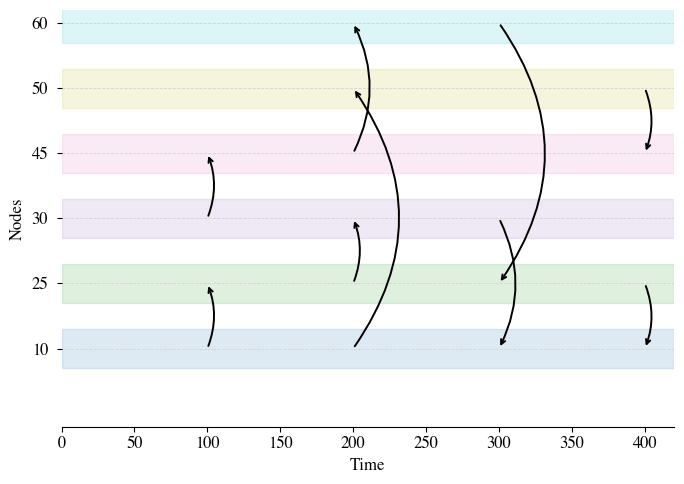

In [4]:
plot_contact_sequence([
    (10, 25, 100),
    (30, 45, 100),
    (25, 30, 200),
    (45, 60, 200),
    (10, 50, 200),
    (30, 10, 300),
    (60, 25, 300),
    (50, 45, 400),
    (25, 10, 400)
])

In [2]:
import os
import pandas as pd

file_dir = '/Volumes/traces/final_data_files/'

file_paths = [os.path.join(file_dir, f'data_{file_id}.parquet') for file_id in range(1440, 1680)]
dfs = [pd.read_parquet(file_path).sort_values(by='ts', ascending=True) for file_path in file_paths]

In [3]:
merged_df = pd.concat(dfs)

In [4]:
selected_df = merged_df[['u', 'i', 'ts']]

In [5]:
selected_df.to_parquet('/Users/ashfaqsalehin/Downloads/4_hour_data.parquet')

In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-subreddit 2/tgbl-subreddit_edgelist.csv')

all_ids = pd.concat([df['user_id'], df['item_id']]).unique()

# Create single encoder for all nodes
node_encoder = LabelEncoder()
node_encoder.fit(all_ids)

# Encode both columns using the same encoder
df['user_id'] = node_encoder.transform(df['user_id'])
df['item_id'] = node_encoder.transform(df['item_id'])

df = df[['user_id', 'item_id', 'timestamp']].copy()
df.columns = ['u', 'i', 'ts']

df['ts'] = df['ts'] - df['ts'].min()
df = df.sort_values('ts').reset_index(drop=True)

In [14]:
df.to_csv('/Users/ashfaqsalehin/Downloads/reddit.csv', index=False)

In [18]:
df = pd.read_csv('/Users/ashfaqsalehin/Downloads/wiki.csv')

In [19]:
df['ts'].unique()

array([ 0.        , 13.20056788, 26.40113576, 39.60170364, 52.80227152,
       66.0028394 ])

In [42]:
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-flight-v2/tgbl-flight_edgelist_v2.csv')

In [43]:
df.columns

Index(['timestamp', 'src', 'dst', 'callsign', 'typecode'], dtype='object')

In [44]:
from sklearn.preprocessing import LabelEncoder

all_nodes = pd.concat([df['src'], df['dst']], ignore_index=True).unique()

# Initialize and fit label encoder on all unique nodes
label_encoder = LabelEncoder()
label_encoder.fit(all_nodes)

# Transform user_id and item_id using the same encoder
df['src'] = label_encoder.transform(df['src'])
df['dst'] = label_encoder.transform(df['dst'])

In [45]:
df = df[['src', 'dst', 'timestamp']]

In [46]:
df.columns = ['u', 'i', 'ts']
df = df.sort_values('ts').reset_index(drop=True)

original_min_ts = df['ts'].min()
if original_min_ts < 0:
    df['ts'] = df['ts'] - original_min_ts

In [47]:
df.to_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv', index=False)

In [48]:
df = pd.read_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv')
len(df)

67169570

In [1]:
from tgb.linkproppred.dataset import LinkPropPredDataset

name = "tgbl-coin"

dataset = LinkPropPredDataset(name=name, root="datasets", preprocess=True)

data = dataset.full_data

Dataset tgbl-coin version 2 not found.
Please download the latest version of the dataset.
Download started, this might take a while . . . 
Dataset title: tgbl-coin
Download completed 
Dataset directory is  /Users/ashfaqsalehin/PycharmProjects/temporal-random-walk-test/.venv/lib/python3.10/site-packages/tgb/datasets/tgbl_coin
file not processed, generating processed file
number of lines counted 22809486
numpy allocated


22809487it [00:50, 455805.56it/s]


In [19]:
full_data = dataset.full_data

In [20]:
train_sources = full_data['sources'][dataset.train_mask]
train_targets = full_data['destinations'][dataset.train_mask]
train_timestamps = full_data['timestamps'][dataset.train_mask]

val_sources = full_data['sources'][dataset.val_mask]
val_targets = full_data['destinations'][dataset.val_mask]
val_timestamps = full_data['timestamps'][dataset.val_mask]

test_sources = full_data['sources'][dataset.test_mask]
test_targets = full_data['destinations'][dataset.test_mask]
test_timestamps = full_data['timestamps'][dataset.test_mask]

In [21]:
dataset.load_val_ns()

In [ ]:
import torch

val_sources_tensor = torch.tensor(val_sources)
val_targets_tensor = torch.tensor(val_targets)
val_timestamps_tensor = torch.tensor(val_timestamps)

dataset.ns_sampler.query_batch(val_sources_tensor, )

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/TEA-datasets/csv_datasets/yahoo-song.csv')
ts = df['ts'].to_numpy()
unique_timestamps = np.unique(ts)

unique_timestamps.sort()

In [98]:
len(unique_timestamps), list(unique_timestamps).index(264101580)

(4357526, 103517)

In [99]:
df = pd.read_parquet('/Users/ashfaqsalehin/Downloads/4_hour_data.parquet')

In [100]:
df

,u,i,ts
5789660015,65094,17932,86400000
5789660052,51804,51804,86400000
5789660053,44870,52118,86400000
5789660054,44870,22617,86400000
5789660055,64996,27884,86400000
...,...,...,...
6494499987,54423,18819,100799999
6494499986,67001,31913,100799999
6494500014,67001,62215,100799999
6494499999,64996,27884,100799999


In [101]:
unique_timestamps = np.unique(df['ts'].to_numpy())

In [1]:
import numpy as np
from typing import Tuple, Optional


def generate_temporal_graph(num_nodes: int,
                           num_edges: int,
                           num_timestamps: int,
                           time_range: Tuple[int, int] = (0, 1_000_000_000),
                           random_state: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if random_state is not None:
        np.random.seed(random_state)

    if num_edges <= 0:
        return np.array([]), np.array([]), np.array([])

    if num_timestamps <= 0 or num_nodes <= 0:
        raise ValueError("num_timestamps and num_nodes must be positive")

    # Step 1: Generate exactly num_timestamps unique timestamps
    min_time, max_time = time_range

    # Ensure we have enough range for unique timestamps
    time_span = max_time - min_time + 1
    if num_timestamps > time_span:
        raise ValueError(f"Cannot generate {num_timestamps} unique timestamps in range {time_range}")

    # Generate exactly num_timestamps unique timestamps
    unique_timestamps = np.random.choice(
        np.arange(min_time, max_time + 1, dtype=np.int64),
        size=num_timestamps,
        replace=False
    )
    unique_timestamps = np.sort(unique_timestamps)

    # Step 2: Randomly assign each edge to one of the timestamps
    edge_timestamps = np.random.choice(unique_timestamps, size=num_edges)

    # Step 3: Generate random source and target nodes (self-loops allowed)
    sources = np.random.randint(0, num_nodes, size=num_edges)
    targets = np.random.randint(0, num_nodes, size=num_edges)

    # Step 4: Sort everything by timestamp
    sort_indices = np.argsort(edge_timestamps)

    return (sources[sort_indices],
            targets[sort_indices],
            edge_timestamps[sort_indices])

In [5]:
np.logspace(start=1, stop=8, num=8, base=10, dtype=int)

array([       10,       100,      1000,     10000,    100000,   1000000,
        10000000, 100000000])

In [19]:
import json

with open('/Users/ashfaqsalehin/Downloads/twibot22/tweet_0.json', 'r') as file:
    loaded_data = json.load(file)

In [20]:
len(loaded_data)

10000000

In [1]:
loaded_data[10]

NameError: name 'loaded_data' is not defined

In [28]:
from datetime import datetime

dt = datetime.fromisoformat(loaded_data[0]['created_at'])
unix_timestamp = dt.timestamp()

In [29]:
unix_timestamp

1645937975.0

In [2]:
import pandas as pd

edges_data = pd.read_csv('/Users/ashfaqsalehin/Downloads/twibot22_preprocessed/edges.csv')

In [3]:
edges_data

,u,i,ts,relation
0,9680911,647792,1179510562,mentioned
1,9680911,647792,1179510562,replied
2,9680911,647792,1179708838,mentioned
3,9680911,647792,1179708838,replied
4,8045335,1478968,1180688723,replied
...,...,...,...,...
114968515,8849105,6176846,1647273198,mentioned
114968516,8849105,6176846,1647273198,replied
114968517,8849105,2874398,1647273268,mentioned
114968518,6910750,6910750,1647294105,replied


min_ts: 1179510562 (2007-05-18T17:49:22Z)
max_ts: 1647305711 (2022-03-15T00:55:11Z)
buckets: 20, approx bucket width: 23389757.45 sec (~270.71 days)
median edges/bucket: 305642, empty buckets: 0


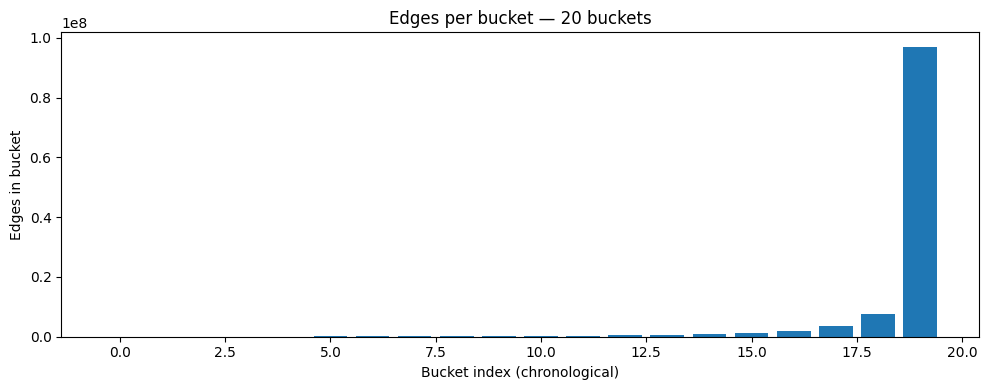

In [12]:
# Min/max ts, divide into N buckets, plot edge counts

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

NUM_BUCKETS = 20  # ← change this if you want

# grab timestamps
ts = pd.to_numeric(edges_data["ts"], errors="coerce").dropna().to_numpy()

# if timestamps look like milliseconds, convert to seconds
if ts.max() > 1_000_000_000_000:
    ts = (ts // 1000).astype(np.int64)
else:
    ts = ts.astype(np.int64)

ts_min = int(ts.min())
ts_max = int(ts.max())

print(f"min_ts: {ts_min} ({datetime.utcfromtimestamp(ts_min).isoformat()}Z)")
print(f"max_ts: {ts_max} ({datetime.utcfromtimestamp(ts_max).isoformat()}Z)")

# bucketize uniformly over [min, max]
counts, bin_edges = np.histogram(ts, bins=NUM_BUCKETS, range=(ts_min, ts_max + 1))

bucket_width = (ts_max - ts_min) / NUM_BUCKETS
print(f"buckets: {NUM_BUCKETS}, approx bucket width: {bucket_width:.2f} sec (~{bucket_width/86400:.2f} days)")
print(f"median edges/bucket: {np.median(counts):.0f}, empty buckets: {(counts==0).sum()}")

# plot
plt.figure(figsize=(10, 4))
plt.bar(np.arange(NUM_BUCKETS), counts)
plt.title(f"Edges per bucket — {NUM_BUCKETS} buckets")
plt.xlabel("Bucket index (chronological)")
plt.ylabel("Edges in bucket")
plt.tight_layout()
plt.show()

In [13]:
counts

array([      74,      492,    10573,    21877,    37656,    79956,
         115066,   160925,   202330,   267085,   344198,   398353,
         498628,   676792,   910375,  1228800,  1826892,  3606847,
        7590299, 96991302])

In [7]:
import os
import pandas as pd
import numpy as np

def _load_edges(data_path):
    edges_path = os.path.join(data_path, 'edges.csv')
    df = pd.read_csv(edges_path)
    df = df[["u", "i", "ts"]].copy()
    df = df.dropna().astype({"u": np.int32, "i": np.int32, "ts": np.int64})
    return df


def _load_labelled_splits(data_path):
    labels = pd.read_csv(os.path.join(data_path, 'labels.csv'), usecols=['id', 'label'])
    labels_dict = {int(i): (1 if lbl == 'bot' else 0) for i, lbl in zip(labels['id'], labels['label'])}

    split = pd.read_csv(os.path.join(data_path, 'split.csv'), usecols=['id', 'split'])

    def pack(name: str):
        ids_all = split.loc[split['split'] == name, 'id'].astype(int).to_numpy()
        ids = [i for i in ids_all if i in labels_dict]
        y = [labels_dict[i] for i in ids]
        return np.array(ids, dtype=np.int32), np.array(y, dtype=np.int32)

    train_ids, train_y = pack('train')
    val_ids,   val_y   = pack('val')
    test_ids,  test_y  = pack('test')

    return train_ids, train_y, val_ids, val_y, test_ids, test_y


In [9]:
data_path = '/Users/ashfaqsalehin/Downloads/twibot22_preprocessed'
edges = _load_edges(data_path)

In [10]:
labels = pd.read_csv(os.path.join(data_path, 'labels.csv'), usecols=['id', 'label'])
split = pd.read_csv(os.path.join(data_path, 'split.csv'), usecols=['id', 'split'])

In [11]:
edge_node_set = set(np.concatenate([edges['u'].to_numpy(), edges['i'].to_numpy()]))
split_node_set = set(split['id'].to_numpy())

In [14]:
label_node_set = set(labels['id'].to_numpy())

In [15]:
split_missing_in_edge = split_node_set - edge_node_set
label_missing_in_edge = label_node_set - edge_node_set
len(split_node_set), len(split_missing_in_edge), len(label_node_set), len(label_missing_in_edge)

(1000000, 83130, 1000000, 83130)

In [17]:
len(label_node_set - split_node_set)

0

In [20]:
train_ids, train_y, val_ids, val_y, test_ids, test_y = _load_labelled_splits('/Users/ashfaqsalehin/Downloads/twibot22_preprocessed')

In [21]:
train_y

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [26]:
unique_elements, counts = np.unique(test_y, return_counts=True)

In [27]:
counts

array([70556, 29444])

In [1]:
import numpy as np

fin_data = np.load('/Users/ashfaqsalehin/Downloads/DGraphFin/dgraphfin.npz')

In [2]:
fin_data

NpzFile '/Users/ashfaqsalehin/Downloads/DGraphFin/dgraphfin.npz' with keys: x, y, edge_index, edge_type, edge_timestamp...

In [12]:
fin_data['train_mask']

array([2735458, 3025736, 2659385, ...,  572867, 3250251, 1337270])

In [5]:
np.min(fin_data['edge_timestamp']), np.max(fin_data['edge_timestamp'])

(1, 821)

In [6]:
unique, counts = np.unique(fin_data['edge_timestamp'], return_counts=True)

In [8]:
counts

array([ 4604,  4638,  4581,  4689,  4667,  4655,  4620,  4589,  4671,
        4679,  4516,  4679,  4774,  4489,  4655,  4743,  4679,  4581,
        4648,  4636,  4626,  4748,  4799,  4647,  4688,  4806,  4632,
        4646,  4721,  4757,  4619,  3942,  5048,  5524,  5193,  5292,
        5620,  6370,  6386,  6842,  6198,  5966,  5277,  5357,  5785,
        5934,  5738,  5507,  5253,  5058,  5314,  5513,  5534,  5063,
        5293,  5406,  4581,  4624,  4842,  4736,  4803,  4540,  4811,
        4446,  3931,  2463,  1831,  1805,  2056,  2368,  2691,  2614,
        3501,  3966,  4144,  4051,  3954,  3878,  3975,  4226,  4186,
        4279,  4318,  4275,  3913,  3974,  4301,  3687,  4073,  4231,
        4556,  3983,  4059,  4309,  4324,  4379,  4453,  4345,  4012,
        3720,  4075,  4009,  4029,  3916,  3980,  3526,  3717,  4141,
        4244,  4075,  3797,  3913,  3838,  3712,  4118,  3980,  4102,
        4182,  4049,  3900,  4031,  4613,  4564,  4667,  4464,  3891,
        3876,  4425,

In [18]:
fin_data['train_mask'], len(fin_data['train_mask'])

(array([2735458, 3025736, 2659385, ...,  572867, 3250251, 1337270]), 857899)

In [19]:
import numpy as np

# Load the data
fin_data = np.load('/Users/ashfaqsalehin/Downloads/DGraphFin/dgraphfin.npz')

print("=== Basic Info ===")
print(f"x shape: {fin_data['x'].shape}")
print(f"y shape: {fin_data['y'].shape}")
print(f"edge_index shape: {fin_data['edge_index'].shape}")

print("\n=== Train Mask Analysis ===")
train_mask = fin_data['train_mask']
print(f"train_mask shape: {train_mask.shape}")
print(f"train_mask first 10 values: {train_mask[:10]}")
print(f"train_mask min: {train_mask.min()}")
print(f"train_mask max: {train_mask.max()}")

print("\n=== Y Labels Analysis ===")
y = fin_data['y']
print(f"y min: {y.min()}")
print(f"y max: {y.max()}")
print(f"Node count: {len(y)}")
print(f"Max possible index: {len(y) - 1}")

print("\n=== Test: Are train_mask values valid indices for y? ===")
print(f"All train_mask values < len(y)? {np.all(train_mask < len(y))}")

print("\n=== Labels at train_mask positions ===")
labels_at_train_positions = y[train_mask[:10]]  # First 10
print(f"y[train_mask[:10]]: {labels_at_train_positions}")

print("\n=== Class distribution in y ===")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count:,} nodes")

print("\n=== Class distribution in train split ===")
train_labels = y[train_mask]
unique_train, counts_train = np.unique(train_labels, return_counts=True)
for cls, count in zip(unique_train, counts_train):
    print(f"Train Class {cls}: {count:,} nodes")

=== Basic Info ===
x shape: (3700550, 17)
y shape: (3700550,)
edge_index shape: (4300999, 2)

=== Train Mask Analysis ===
train_mask shape: (857899,)
train_mask first 10 values: [2735458 3025736 2659385 1031747   88412 1888230 2660095  960647 3030836
 1209386]
train_mask min: 7
train_mask max: 3700541

=== Y Labels Analysis ===
y min: 0
y max: 3
Node count: 3700550
Max possible index: 3700549

=== Test: Are train_mask values valid indices for y? ===
All train_mask values < len(y)? True

=== Labels at train_mask positions ===
y[train_mask[:10]]: [1 1 1 1 1 1 1 1 1 1]

=== Class distribution in y ===
Class 0: 1,210,092 nodes
Class 1: 15,509 nodes
Class 2: 1,620,851 nodes
Class 3: 854,098 nodes

=== Class distribution in train split ===
Train Class 0: 847,042 nodes
Train Class 1: 10,857 nodes


In [22]:
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def comprehensive_dgraphfin_analysis(data_path):
    """Complete analysis for optimal fraud detection model selection"""

    print("COMPREHENSIVE DGRAPHFIN ANALYSIS FOR MODEL OPTIMIZATION")
    print("=" * 70)

    # Load data
    data = np.load(data_path)
    x = data['x']  # Node features
    y = data['y']  # Node labels
    edge_index = data['edge_index']
    edge_timestamp = data['edge_timestamp']
    train_mask = data['train_mask']
    valid_mask = data['valid_mask']
    test_mask = data['test_mask']

    print(f"1. DATASET OVERVIEW")
    print(f"   Nodes: {x.shape[0]:,}, Features: {x.shape[1]}")
    print(f"   Edges: {edge_index.shape[0]:,}")
    print(f"   Train/Val/Test: {len(train_mask):,}/{len(valid_mask):,}/{len(test_mask):,}")

    # Class distribution with splits
    print(f"\n2. CLASS DISTRIBUTION & IMBALANCE")
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"   Overall: {dict(zip(unique_classes, class_counts))}")

    # Binary classification analysis
    train_labels = y[train_mask]
    val_labels = y[valid_mask]
    test_labels = y[test_mask]

    splits_analysis = {}
    for split_name, labels in [("Train", train_labels), ("Val", val_labels), ("Test", test_labels)]:
        fraud = np.sum(labels == 1)
        normal = np.sum(labels == 0)
        total = len(labels)
        ratio = normal / fraud if fraud > 0 else 0
        fraud_pct = fraud / total * 100

        splits_analysis[split_name] = {
            'fraud': fraud, 'normal': normal, 'ratio': ratio, 'fraud_pct': fraud_pct
        }

        print(f"   {split_name}: {normal:,} normal, {fraud:,} fraud ({ratio:.1f}:1, {fraud_pct:.3f}%)")

    # Feature correlation analysis
    print(f"\n3. FEATURE CORRELATION ANALYSIS")
    # Sample for large datasets
    sample_size = min(100000, len(x))
    sample_idx = np.random.choice(len(x), sample_size, replace=False)
    x_sample = x[sample_idx]

    corr_matrix = np.corrcoef(x_sample.T)

    # Find high correlations
    high_corr_pairs = []
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            corr_val = corr_matrix[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((i, j, corr_val))

    print(f"   Correlation matrix computed for {sample_size:,} samples")
    print(f"   High correlations (|r| > 0.7): {len(high_corr_pairs)} pairs")

    if high_corr_pairs:
        high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        print(f"   Top correlated pairs:")
        for i, j, corr in high_corr_pairs[:5]:
            print(f"     F{i}-F{j}: {corr:.3f}")
    else:
        print(f"   No highly correlated features found")

    # Feature redundancy assessment
    redundant_features = set()
    for i, j, corr in high_corr_pairs:
        if abs(corr) > 0.9:
            redundant_features.add(max(i, j))  # Remove higher index

    print(f"   Potentially redundant features (|r| > 0.9): {sorted(redundant_features)}")

    # Distribution analysis for each feature
    print(f"\n4. FEATURE DISTRIBUTION ANALYSIS")
    print(f"   {'Feature':<8} {'Mean':<8} {'Std':<8} {'Skew':<8} {'Kurt':<8} {'Outliers':<8} {'Distribution':<12}")
    print(f"   {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*12}")

    distribution_summary = {}

    for i in range(x.shape[1]):
        feat = x[:, i]

        # Basic stats
        mean_val = np.mean(feat)
        std_val = np.std(feat)
        skew_val = skew(feat)
        kurt_val = kurtosis(feat)

        # Outlier detection using IQR
        q75, q25 = np.percentile(feat, [75, 25])
        iqr = q75 - q25
        lower_bound = q25 - (1.5 * iqr)
        upper_bound = q75 + (1.5 * iqr)
        outliers = np.sum((feat < lower_bound) | (feat > upper_bound))
        outlier_pct = outliers / len(feat) * 100

        # Classify distribution
        if abs(skew_val) < 0.5:
            dist_type = "normal"
        elif skew_val > 1:
            dist_type = "right_skewed"
        elif skew_val < -1:
            dist_type = "left_skewed"
        else:
            dist_type = "slight_skew"

        if kurt_val > 3:
            dist_type += "_heavy_tail"

        distribution_summary[i] = {
            'skew': skew_val, 'kurtosis': kurt_val, 'outliers': outlier_pct, 'type': dist_type
        }

        print(f"   F{i:<7} {mean_val:<8.3f} {std_val:<8.3f} {skew_val:<8.3f} {kurt_val:<8.3f} {outlier_pct:<8.1f} {dist_type:<12}")

    # Feature discrimination with effect sizes
    print(f"\n5. FEATURE DISCRIMINATION ANALYSIS")
    binary_mask = (y == 0) | (y == 1)
    x_binary = x[binary_mask]
    y_binary = y[binary_mask]

    class_0_features = x_binary[y_binary == 0]
    class_1_features = x_binary[y_binary == 1]

    discrimination_results = []

    print(f"   {'Feature':<8} {'Normal':<8} {'Fraud':<8} {'Diff':<8} {'Effect':<8} {'T-stat':<10} {'P-value':<10} {'Rank':<6}")
    print(f"   {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*10} {'-'*10} {'-'*6}")

    for i in range(x.shape[1]):
        normal_feat = class_0_features[:, i]
        fraud_feat = class_1_features[:, i]

        normal_mean = np.mean(normal_feat)
        fraud_mean = np.mean(fraud_feat)
        diff = fraud_mean - normal_mean

        # Cohen's d effect size
        pooled_std = np.sqrt(((len(normal_feat)-1)*np.var(normal_feat) + (len(fraud_feat)-1)*np.var(fraud_feat)) /
                           (len(normal_feat) + len(fraud_feat) - 2))
        effect_size = abs(diff) / pooled_std if pooled_std > 0 else 0

        # Statistical test
        try:
            t_stat, p_val = stats.ttest_ind(normal_feat, fraud_feat, equal_var=False)
        except:
            t_stat, p_val = 0, 1

        # Rank effect size
        if effect_size >= 0.8:
            rank = "Large"
        elif effect_size >= 0.5:
            rank = "Medium"
        elif effect_size >= 0.2:
            rank = "Small"
        else:
            rank = "Tiny"

        discrimination_results.append((i, effect_size, abs(t_stat), p_val, rank))

        print(f"   F{i:<7} {normal_mean:<8.3f} {fraud_mean:<8.3f} {diff:<8.3f} {effect_size:<8.3f} {t_stat:<10.3f} {p_val:<10.2e} {rank:<6}")

    # Rank features by discrimination power
    discrimination_results.sort(key=lambda x: x[1], reverse=True)
    print(f"\n   Features ranked by effect size:")
    print(f"   Top 5: {[f'F{x[0]}({x[4]})' for x in discrimination_results[:5]]}")
    print(f"   Bottom 5: {[f'F{x[0]}({x[4]})' for x in discrimination_results[-5:]]}")

    # Temporal analysis
    print(f"\n6. TEMPORAL PATTERN ANALYSIS")

    # Edge timestamp distribution
    ts_min, ts_max = edge_timestamp.min(), edge_timestamp.max()
    ts_range = ts_max - ts_min
    unique_ts = len(np.unique(edge_timestamp))

    print(f"   Timestamp range: [{ts_min:,}, {ts_max:,}] (span: {ts_range:,})")
    print(f"   Unique timestamps: {unique_ts:,}")
    print(f"   Average edges per timestamp: {len(edge_timestamp)/unique_ts:.1f}")

    # Temporal binning analysis
    n_bins = 10
    hist, bin_edges = np.histogram(edge_timestamp, bins=n_bins)
    print(f"   Temporal distribution ({n_bins} bins):")
    for i in range(len(hist)):
        start_bin = bin_edges[i]
        end_bin = bin_edges[i+1]
        count = hist[i]
        pct = count / len(edge_timestamp) * 100
        print(f"     Bin {i+1}: [{start_bin:,.0f}, {end_bin:,.0f}) -> {count:,} edges ({pct:.1f}%)")

    # Check for temporal bias in node splits
    print(f"\n   Node split temporal analysis:")
    for split_name, mask in [("Train", train_mask), ("Val", valid_mask), ("Test", test_mask)]:
        # Find edges involving nodes in this split
        split_edges = []
        for edge_idx in range(len(edge_index)):
            src, dst = edge_index[edge_idx]
            if src in mask or dst in mask:
                split_edges.append(edge_timestamp[edge_idx])

        if split_edges:
            split_ts_min, split_ts_max = min(split_edges), max(split_edges)
            print(f"     {split_name}: timestamps [{split_ts_min:,}, {split_ts_max:,}]")

    # Feature scaling necessity assessment
    print(f"\n7. FEATURE SCALING ASSESSMENT")

    # Calculate scale ratios
    feature_ranges = []
    for i in range(x.shape[1]):
        feat_min, feat_max = x[:, i].min(), x[:, i].max()
        feat_range = feat_max - feat_min
        feature_ranges.append(feat_range)

    max_range = max(feature_ranges)
    min_range = min([r for r in feature_ranges if r > 0])
    scale_ratio = max_range / min_range if min_range > 0 else float('inf')

    print(f"   Feature range span: {min_range:.3f} to {max_range:.3f}")
    print(f"   Scale ratio (max/min): {scale_ratio:.1f}")

    if scale_ratio > 100:
        scaling_necessity = "CRITICAL"
    elif scale_ratio > 10:
        scaling_necessity = "HIGHLY_RECOMMENDED"
    elif scale_ratio > 3:
        scaling_necessity = "RECOMMENDED"
    else:
        scaling_necessity = "OPTIONAL"

    print(f"   Scaling necessity: {scaling_necessity}")

    # Loss function suitability analysis
    print(f"\n8. LOSS FUNCTION SUITABILITY ANALYSIS")

    imbalance_ratio = splits_analysis['Train']['ratio']
    fraud_samples = splits_analysis['Train']['fraud']

    print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
    print(f"   Fraud samples: {fraud_samples:,}")

    # Analyze class separability for different loss functions
    separability_score = np.mean([x[1] for x in discrimination_results])

    print(f"   Average effect size: {separability_score:.3f}")

    loss_recommendations = []

    if imbalance_ratio < 10:
        loss_recommendations.append("Standard BCE (mild imbalance)")
    elif imbalance_ratio < 50:
        loss_recommendations.append("Weighted BCE (moderate imbalance)")
    elif imbalance_ratio < 200:
        loss_recommendations.append("Weighted BCE or Focal Loss")
    else:
        loss_recommendations.append("Focal Loss (extreme imbalance)")

    if separability_score > 0.5:
        loss_recommendations.append("Strong separability supports simpler losses")
    else:
        loss_recommendations.append("Weak separability may need advanced losses")

    print(f"   Loss function recommendations: {loss_recommendations}")

    # Model architecture recommendations
    print(f"\n9. MODEL ARCHITECTURE RECOMMENDATIONS")

    n_features = x.shape[1]
    n_discriminative = len([x for x in discrimination_results if x[1] > 0.2])
    n_redundant = len(redundant_features)

    print(f"   Features: {n_features} total, {n_discriminative} discriminative, {n_redundant} redundant")

    # Architecture complexity assessment
    if n_features <= 20 and n_discriminative >= n_features * 0.7:
        arch_rec = "SIMPLE_MLP (2-3 layers)"
        complexity_justification = "Small, highly discriminative feature set"
    elif n_features <= 50:
        arch_rec = "MODERATE_MLP (3-4 layers)"
        complexity_justification = "Medium feature set"
    else:
        arch_rec = "DEEP_MLP or feature selection"
        complexity_justification = "Large feature set"

    # Check if attention is justified
    attention_justified = False
    if n_features > 50 or separability_score < 0.3:
        attention_justified = True
        attention_reason = "Complex feature interactions needed"
    else:
        attention_reason = "Simple concatenation sufficient"

    print(f"   Recommended architecture: {arch_rec}")
    print(f"   Justification: {complexity_justification}")
    print(f"   Attention mechanism: {'JUSTIFIED' if attention_justified else 'OVERKILL'}")
    print(f"   Attention reasoning: {attention_reason}")

    # Data quality assessment
    print(f"\n10. DATA QUALITY ASSESSMENT")

    # Missing values
    missing_features = []
    for i in range(x.shape[1]):
        if np.isnan(x[:, i]).any():
            missing_features.append(i)

    print(f"   Missing values: {len(missing_features)} features affected")

    # Zero-heavy features
    zero_heavy = []
    for i in range(x.shape[1]):
        zero_pct = np.sum(x[:, i] == 0) / len(x[:, i]) * 100
        if zero_pct > 50:
            zero_heavy.append((i, zero_pct))

    print(f"   Zero-heavy features (>50% zeros): {len(zero_heavy)}")
    for feat_idx, zero_pct in zero_heavy:
        print(f"     F{feat_idx}: {zero_pct:.1f}% zeros")

    # Final integrated recommendations
    print(f"\n11. INTEGRATED RECOMMENDATIONS")
    print(f"=" * 50)

    print(f"PREPROCESSING:")
    print(f"  - Feature scaling: {scaling_necessity}")
    if len(redundant_features) > 0:
        print(f"  - Remove redundant features: {sorted(redundant_features)}")
    if len(zero_heavy) > 0:
        print(f"  - Consider log transform for zero-heavy features")

    print(f"\nMODEL ARCHITECTURE:")
    print(f"  - {arch_rec}")
    print(f"  - Input dimension: {n_features - len(redundant_features)}")
    print(f"  - Attention: {attention_reason}")

    print(f"\nLOSS FUNCTION:")
    for rec in loss_recommendations:
        print(f"  - {rec}")

    print(f"\nTRAINING STRATEGY:")
    print(f"  - Batch size: 64-128 (small fraud class)")
    print(f"  - Stratified sampling: Essential")
    print(f"  - Early stopping: Critical")
    print(f"  - Metrics: Focus on AUC, PR-AUC")

    return {
        'imbalance_ratio': imbalance_ratio,
        'scale_ratio': scale_ratio,
        'discriminative_features': n_discriminative,
        'redundant_features': list(redundant_features),
        'correlation_pairs': high_corr_pairs,
        'architecture_rec': arch_rec,
        'attention_justified': attention_justified,
        'scaling_necessity': scaling_necessity
    }

# Run analysis
data_path = '/Users/ashfaqsalehin/Downloads/DGraphFin/dgraphfin.npz'
results = comprehensive_dgraphfin_analysis(data_path)

COMPREHENSIVE DGRAPHFIN ANALYSIS FOR MODEL OPTIMIZATION
1. DATASET OVERVIEW
   Nodes: 3,700,550, Features: 17
   Edges: 4,300,999
   Train/Val/Test: 857,899/183,862/183,840

2. CLASS DISTRIBUTION & IMBALANCE
   Overall: {0: 1210092, 1: 15509, 2: 1620851, 3: 854098}
   Train: 847,042 normal, 10,857 fraud (78.0:1, 1.266%)
   Val: 181,536 normal, 2,326 fraud (78.0:1, 1.265%)
   Test: 181,514 normal, 2,326 fraud (78.0:1, 1.265%)

3. FEATURE CORRELATION ANALYSIS
   Correlation matrix computed for 100,000 samples
   High correlations (|r| > 0.7): 42 pairs
   Top correlated pairs:
     F6-F8: 1.000
     F4-F9: 0.998
     F11-F12: 0.995
     F2-F3: 0.994
     F15-F16: 0.984
   Potentially redundant features (|r| > 0.9): [3, 8, 9, 10, 11, 12, 13, 14, 16]

4. FEATURE DISTRIBUTION ANALYSIS
   Feature  Mean     Std      Skew     Kurt     Outliers Distribution
   -------- -------- -------- -------- -------- -------- ------------
   F0       0.508    0.738    -1.126   -0.259   0.0      left_skewed 


In [1]:
import pandas as pd

df = pd.read_parquet('/Users/ashfaqsalehin/Downloads/ml_tgbl-coin.parquet')

In [2]:
df

,u,i,ts,label,idx,w
0,0.0,1.0,1.648811e+09,0.0,1.0,9.643856
1,2.0,3.0,1.648811e+09,0.0,2.0,13.956558
2,4.0,5.0,1.648811e+09,0.0,3.0,9.348010
3,6.0,7.0,1.648811e+09,0.0,4.0,11.941594
4,8.0,9.0,1.648811e+09,0.0,5.0,13.674752
...,...,...,...,...,...,...
22809481,13231.0,315673.0,1.667278e+09,0.0,22809482.0,3.362205
22809482,617066.0,603068.0,1.667278e+09,0.0,22809483.0,6.312962
22809483,113.0,10657.0,1.667278e+09,0.0,22809484.0,7.989242
22809484,624965.0,637270.0,1.667278e+09,0.0,22809485.0,13.889714


In [3]:
df.to_csv("/Users/ashfaqsalehin/Downloads/ml_tgbl-coin.csv", index=False)